# Project Vehicle Detection and Tracking

## Histogram of Oriented Gradients (HOG)

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

### Load Test Images

In [19]:
def load_images(pathname):
    print('Loading test images from', pathname)
    return list(map(lambda filename: (filename, cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)), glob.glob(pathname)))

# All images are png's and 64x64 pixels
vehicles_images = load_images('./training_images/vehicles/*/*png')
non_vehicles_images = load_images('./training_images/non-vehicles/*/*png')

print('Vehicle train image count: {}'.format(len(vehicles_images)))
print('Non-vehicle train image count: {}'.format(len(non_vehicles_images)))

Loading test images from  ./training_images/vehicles/*/*png
Loading test images from  ./training_images/non-vehicles/*/*png
Vehicle train image count: 8792
Non-vehicle train image count: 8968


Text(0.5,1,'./training_images/non-vehicles/GTI/image1408.png')

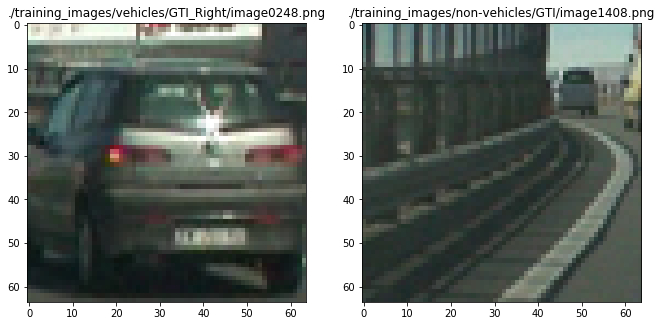

In [75]:
index = 100

vehicle_image_name = vehicles_images[index][0]
non_vehicle_image_name = non_vehicles_images[index][0]

vehicle_image = vehicles_images[index][1]
non_vehicle_image = non_vehicles_images[index][1]

# Show example test images
fig, axes = plt.subplots(ncols=2, figsize=(11, 10))
axes[0].imshow(vehicle_image)
axes[0].set_title(vehicle_image_name)
axes[1].imshow(non_vehicle_image)
axes[1].set_title(non_vehicle_image_name)

### Extract HOG Features

In [41]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import time

In [38]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    
    # Return the feature vector
    return features


# Define a function to compute color histogram features  
def color_hist(image, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features  

    
# Define a function to extract features from an image
def extract_features(image, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):   
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features = []
    if hog_channel == 'ALL':
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, spatial_size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    # Append the new feature vector to the features list
    features = []
    
    #features = np.concatenate((spatial_features, hist_features, hog_features[0], hog_features[1], hog_features[2]))
    #features = np.concatenate((hist_features, hog_features[0], hog_features[1], hog_features[2]))
    #features = np.concatenate((hog_features[0], hog_features[1], hog_features[2]))
    features = np.concatenate((spatial_features, hist_features, hog_features))
    
    # Return list of feature vectors
    return features


# Define a function to extract features from a list of images
def extract_images_features(images, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2 ):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in images:

        image_features = extract_features(image[1], cspace=cspace, spatial_size=spatial_size,
                    hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block )

        features.append(image_features)

    # Return list of feature vectors
    return features

/Users/sebastian/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


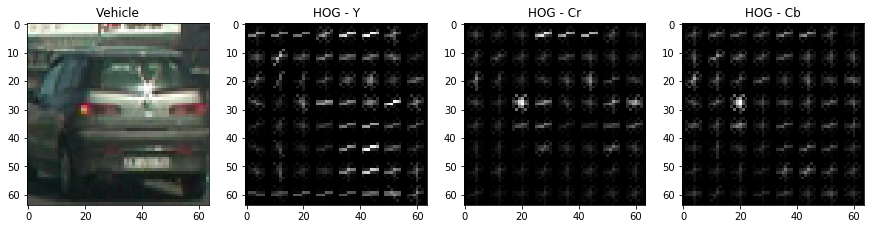

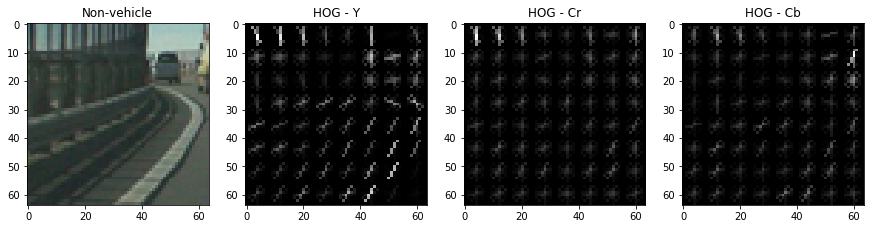

In [79]:
# Calculate HOG on the image `img` and the YCrCb color space and show them on a graph.
def show_hog_image(image, title):
    image_cspaced = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    orient=9
    pix_per_cell=8
    cell_per_block=2
    vis=True
    feature_vec=True
        
    _, hog_y = get_hog_features(image_cspaced[:,:,0], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=2, vis=vis, feature_vec=feature_vec)
    
    _, hog_Cr = get_hog_features(image_cspaced[:,:,1], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=2, vis=vis, feature_vec=feature_vec)
    
    _, hog_Cb = get_hog_features(image_cspaced[:,:,2], orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=2, vis=vis, feature_vec=feature_vec)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(image)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

show_hog_image(vehicle_image, 'Vehicle')
show_hog_image(non_vehicle_image, 'Non-vehicle')

### Train linear SVM classifier using selected HOG features

In [39]:
# Using YCrCb colorspace
cspace='YCrCb'

vehicle_features = extract_images_features(vehicles_images, cspace=cspace)
print("Extrating feature vectors from vehicle images was successfully")

non_vehicle_features = extract_images_features(non_vehicles_images, cspace=cspace)
print("Extrating feature vectors from non vehicles images was successfully")

Extrating feature vectors from vehicle images...


/Users/sebastian/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extrating feature vectors from non vehicles images...


In [59]:
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC(C=1.0)

# Add a calibrated classifier to get probabilities
clf = CalibratedClassifierCV(svc)

# Check the training time for the Linear SVC Classifier
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Training Linear SVC Classifier was successfully in sec', round(t2-t, 4)) 

# Check the score of the SVC
print('Train Accuracy of Linear SVC Classifier =', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of Linear SVC Classifier =', round(clf.score(X_test, y_test), 4))

Training Linear SVC Classifier was successfully in sec 42.9369
Train Accuracy of Linear SVC Classifier = 1.0
Test Accuracy of Linear SVC Classifier = 0.9929617117117117


In [65]:
# Check the prediction time for a single image sample
t=time.time()
prediction = clf.predict(X_test[100].reshape(1, -1))
prob = clf.predict_proba(X_test[100].reshape(1, -1))
t2 = time.time()
print('Time to predict an image sample with Linear SVC Classifier in sec', round(t2-t, 4))

# print("Prediction {}".format(prediction))
# print("Prob {}".format(prob))

Train Accuracy of Linear SVC Classifier = 1.0
Test Accuracy of Linear SVC Classifier = 0.993
Time to predict an image sample with Linear SVC Classifier in sec 0.0014


## Sliding Window Search